In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def cov(s_i, s_j, var_p=1.0, l=1.0, norm=2):
    '''
    Squarred exponential function.

    Parameters
    ----------
    s_i: array_like
        First point.
    s_j: array_like
        Second point.
    var_p: float
        Prior varince.
    l: float
        Length scale.

    Returns
    -------
    float
        The covariance of the two points.
    '''
    if isinstance(s_i, np.ndarray):
        return var_p * np.exp( - 1 / ( 2 * l **2 ) * np.linalg.norm(s_i - s_j, norm)**2 )
    else:
        return var_p * np.exp( - 1 / ( 2 * l **2 ) * np.abs(s_i - s_j)**2 )

def phi(s, S, K_i_inv, var_p=1.0, l=1.0):
    '''
    Computes the :math:´\phi´ according to the position :math:´s´.

    Parameters
    ----------
    s: array_like
        The position to interpolate.
    S: array_like
        The known sampled positions.
    K_i_inv: array_like
        The i-th row of the inverse system matrix.
    var_p: float
        Prior varince.
    l: float
        The influence of the distance on the interpolation.

    Returns
    -------
    float
        The :math:´phi´ of the i-th row solving the system of equations.
    '''
    K_i = np.array([cov(s_i, s, var_p, l) for s_i in S])
    phi_i = K_i_inv * K_i
    return np.sum(phi_i)

def kriging(S, f, var, s_interpolated, var_p, l):
    '''
    Computes a multivatiate random field using kriging based on the observed points `S` and values `f`.

    Parameters
    ----------
    S: array_like
        Sampled points positions.
    f: array_like
        Values observed at the sampled points.
    var: array_like
        The (estimated) variance of the observed values.
    s_interpolated: array_like
        Points to interpolate the new values.
    var_p: float
        Prior varince.
    l: float
        The influence of the distance on the interpolation.

    Returns
    -------
    mu_interpolated: array_like
        The interpolated mean values.
    var_interplated: array_like
        The interpolated variance.
    '''
    K = np.array([
    [cov(S[i], S[j], var_p, l) for j in range(len(f))]
        for i in range(len(f))])
    K += np.diag(var)

    K_inv = np.linalg.inv(K)

    mu_interpolated = np.array([
        [phi(s, S, K_inv[i,:], var_p, l) for i in range(len(f))]
    for s in s_interpolated]) @ f

    var_sum = np.array([
        [phi(s, S, K_inv[i,:], var_p, l) * cov(S[i], s, var_p, l) for i in range(len(f))]
    for s in s_interpolated])

    var_interpolated = np.array([cov(s, s, var_p, l) for s in s_interpolated]) - np.sum(var_sum, axis=1)

    return mu_interpolated, var_interpolated

def piecewise_kriging(S, f, var_i, scale, var_p, l, confidence=3):
    influence_width = int(np.ceil(confidence * l))

    result_x = []
    result_mu = []
    result_var = []
    for i in range(influence_width, S.shape[0] - influence_width - 1):
        f_subset = f[i-influence_width:i+influence_width+2]
        var_i_subset = var_i[i-influence_width:i+influence_width+2]
        s_subset = S[i-influence_width:i+influence_width+2]

        s_interpolated = np.linspace(s_subset[0], s_subset[-1], (s_subset.shape[0] - 1) * scale + 1)

        mu_interpolant, var_interpolant = kriging(s_subset, f_subset, var_i_subset, s_interpolated, var_p, l)

        s_segment = s_interpolated[influence_width * scale: (influence_width + 1) * scale + 1 ]
        mu_segment = mu_interpolant[influence_width * scale: (influence_width + 1) * scale + 1 ]
        var_segment = var_interpolant[influence_width * scale: (influence_width + 1) * scale + 1 ]

        result_x.append( s_segment )
        result_mu.append( mu_segment )
        result_var.append( var_segment )

    result_x = np.array(result_x)
    result_mu = np.array(result_mu)
    result_var = np.array(result_var)
    result_std = np.sqrt(result_var)

    return result_x, result_mu, result_var

def moment(S, mu, var, scale):
    result_x = []
    result_mu = []
    result_var = []

    for i in range(S.shape[0] - 1):
        s_interpolated = np.linspace(S[i], S[i + 1], scale + 1)

        mu_interpolated = np.interp(s_interpolated, S[i:i + 2], mu[i:i + 2])
        var_interpolated = np.interp(s_interpolated, S[i:i + 2], var[i:i + 2])

        result_x.append(s_interpolated)
        result_mu.append(mu_interpolated)
        result_var.append(var_interpolated)

    return result_x, result_mu, result_var


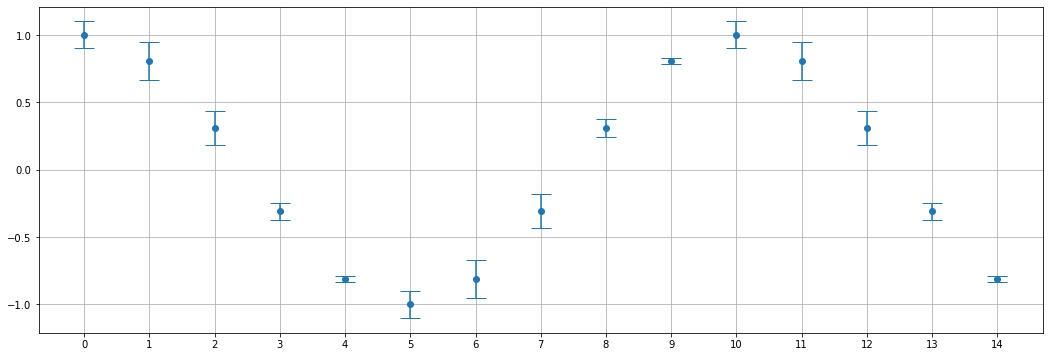

In [3]:
x = np.arange(15)

f = np.cos( x * np.pi/5 )
var_i = np.sin( x * np.pi/2.5 ) * 0.01 + 0.01

plt.figure(figsize=(18,6))
plt.errorbar(x, f, yerr=np.sqrt(var_i), fmt='o', color='tab:blue', capsize=10)
plt.xticks(x)
plt.grid()
plt.show()

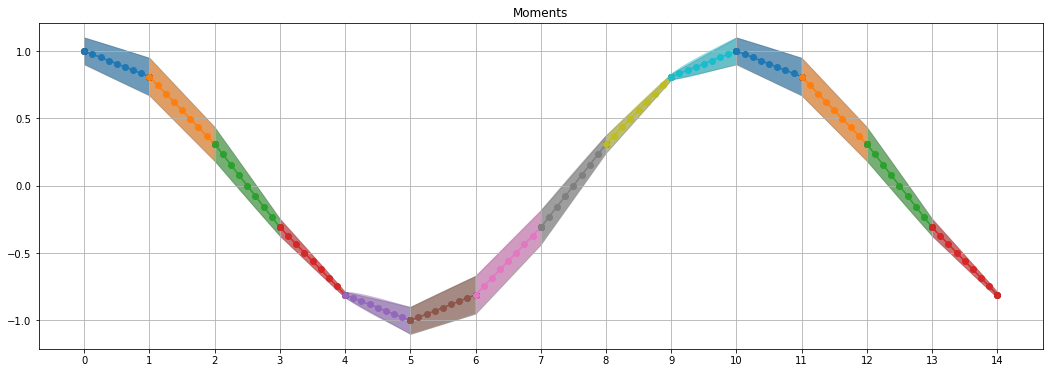

In [4]:
x_moment, mu_moment, var_moment = moment(x, f, var_i, 8)
std_moment = [np.sqrt(var) for var in var_moment]

plt.figure(figsize=(18,6))
plt.title('Moments')
plt.plot(x, f, marker='o', ls='none', c='k')
plt.fill_between(x, f - np.sqrt(var_i), f + np.sqrt(var_i), color='k', alpha=0.25)
for i in range(len(x_moment)):
    plt.plot(x_moment[i], mu_moment[i], marker='o')
    segement = plt.fill_between(x_moment[i], mu_moment[i] - std_moment[i], mu_moment[i] + std_moment[i], alpha=0.5)

plt.xticks(x)
plt.grid()
plt.show()

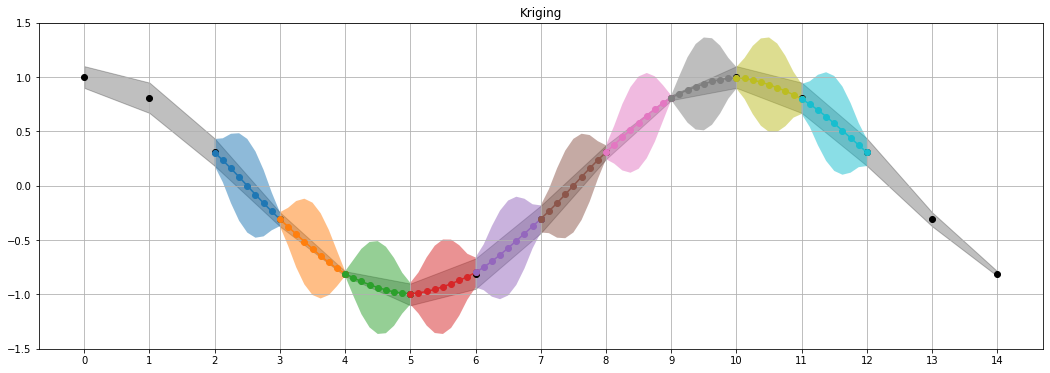

In [5]:
x_kriging, mu_kriging, var_kriging = piecewise_kriging(x, f, var_i, 8, 1.0, 0.6)
std_kriging = [np.sqrt(var) for var in var_kriging]

plt.figure(figsize=(18,6))
plt.title('Kriging')
plt.plot(x, f, marker='o', ls='none', c='k')
plt.fill_between(x, f - np.sqrt(var_i), f + np.sqrt(var_i), color='k', alpha=0.25)
for i in range(len(x_kriging)):
    plt.plot(x_kriging[i], mu_kriging[i], marker='o')
    segement = plt.fill_between(x_kriging[i], mu_kriging[i] - std_kriging[i], mu_kriging[i] + std_kriging[i], alpha=0.5)

plt.xticks(x)
plt.grid()
plt.show()

In [6]:
def wasserstein(mu1, var1, mu2, var2):
    return np.sqrt(
        ( mu1 - mu2 )**2 + ( np.sqrt(var1) - np.sqrt(var2) )**2
    )

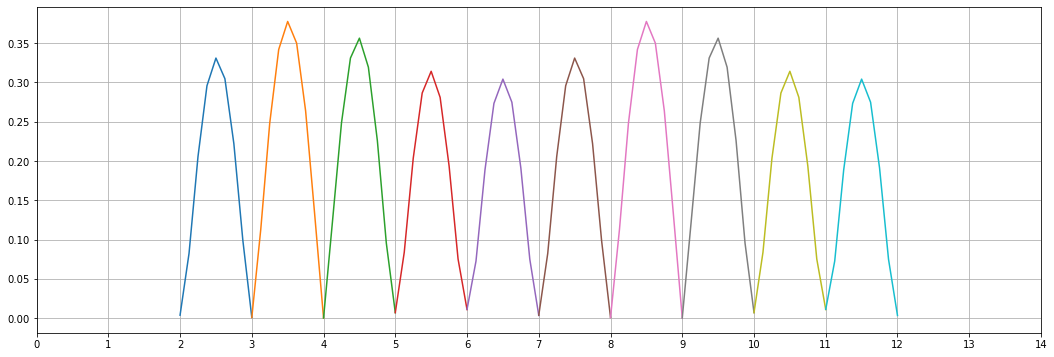

In [7]:
plt.figure(figsize=(18,6))
for i in range(len(x_kriging)):
    diff = wasserstein(mu_moment[i+2], var_moment[i+2], mu_kriging[i], var_kriging[i])

    plt.plot(x_kriging[i], diff)

plt.xticks(x)
plt.grid()
plt.show()